In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import cv2
import numpy as np
from utils.Dataset import get_xray_dataloader
from utils.Transforms import ContrastAdjustment, Normalize
from utils.SCN import SCN
import time
import torch
from torch import optim
import math

In [9]:
dataloader = get_xray_dataloader(open(".\\datasources\\cross_validation_set_2.pt", "rb"), transforms=[ContrastAdjustment(), Normalize()], short=True)

In [3]:
lr = 1e-6
momentum = 0.99
weight_decay = 0.0005
alpha = 20

In [4]:
class ConvertToHeatmaps(object):
    def __init__(self, image_size=(512, 512)):
        self.image_size = image_size
    def generate_heatmap(self, coords, sigma, device="cpu"):
        # landmark holds the image
        normalize_center = False
        sigma_scale_factor=1.0
        size_sigma_factor = 10
        dim = 2
        heatmap = torch.zeros(self.image_size, dtype=torch.float32, device=device)
        flipped_coords = torch.flip(coords, dims=[0])
        region_start = (flipped_coords - sigma * size_sigma_factor / 2).type(torch.int).to(device)
        region_end = (flipped_coords + sigma * size_sigma_factor / 2).type(torch.int).to(device)

        region_start = torch.max(torch.zeros_like(region_start, device=device), region_start).type(torch.int)
        region_end = torch.min(torch.zeros_like(region_end, device=device).fill_(self.image_size[0]), region_end).type(torch.int)
        
        if torch.any(region_start >= region_end):
            return heatmap

        region_size = (region_end - region_start).type(torch.int)

        sigma = sigma * sigma_scale_factor
        scale = 1

        if normalize_center is not True:
            scale /= 2*math.pi*torch.pow(sigma, 2)

        dy, dx = torch.meshgrid(torch.tensor(range(region_size[1]), device=device), torch.tensor(range(region_size[0]), device=device))
        x_diff = (dx + region_start[0] - flipped_coords[0])
        y_diff = (dy + region_start[1] - flipped_coords[1])

        squared_distances = (x_diff * x_diff + y_diff * y_diff)
        cropped_heatmap = (scale * torch.exp(-squared_distances / (2 * torch.pow(sigma, 2))))
        heatmap[region_start[0]:region_end[0],
        region_start[1]:region_end[1]] = cropped_heatmap[:, :].T
        
        return heatmap
    
    def __call__(self, landmarks, sigmas):
        device = "cpu"
        if torch.is_tensor(landmarks):
            landmarks = landmarks.squeeze_(dim=0)
            if landmarks.get_device() > -1:
                device = "cuda"
        heatmaps = np.zeros((landmarks.shape[0], self.image_size[0], self.image_size[1]), dtype=np.float32)
        
        for landmark in range(landmarks.shape[0]):
            for i in range(self.image_size[0]):
                for j in range(self.image_size[1]):
                    sigma_sqr = sigmas[landmark]*sigmas[landmark]
                    const = 100/(2*math.pi*sigma_sqr)
                    coord = landmarks[landmark]
                    dist = math.sqrt(math.pow(j-coord[0], 2) + math.pow(i-coord[1], 2))
                    heatmaps[landmark, i, j] = const*math.exp(-dist/2*sigma_sqr)
            #heatmaps[landmark] = self.generate_heatmap(landmarks[landmark], sigmas[landmark], device=device)
        #heatmaps = heatmaps.unsqueeze_(dim=0)
        return heatmaps
def kaggle_method(x0, y0, sigma, height=512, width=512):
    x = np.arange(0, height, 1, float) ## (width,)
    y = np.arange(0, width, 1, float)[:, np.newaxis] ## (height,1)
    #print(x.dtype, y.dtype)
    dist = torch.from_numpy( ((x-x0)**2 + (y-y0)**2) )
    return torch.exp(-(dist/ (2*sigma**2)))

def heatmap_new_method(landmarks, sigmas):
    heatmaps = torch.zeros((landmarks.shape[0], 512, 512), dtype=torch.float32, requires_grad=False)
    for lid, landmark in enumerate(landmarks):
        sigma = sigmas[lid]
        
        heatmaps[lid] = kaggle_method(landmark[0], landmark[1], sigma)
        
        #print()
        '''
        region_start = (landmark - 5 * 10)
        region_end = (landmark + 5 * 10)
        region_start = np.maximum(0, region_start).astype(np.int)
        region_end = np.minimum((512,512), region_end).astype(np.int)
        region_size = (region_end - region_start).astype(np.int)
        x = np.arange(0, region_size[0], 1, float) ## (width,)
        y = np.arange(0, region_size[1], 1, float)[:, np.newaxis] ## (height,1)
        #x, y = np.meshgrid(range(region_size[0]), range(region_size[1]))#np.meshgrid(range(512), range(512))
        x_diff, y_diff = x - (landmark[0] - region_start[0]), y - (landmark[1] - region_start[1]) #x-landmark[0], y-landmark[1] #
        dist = torch.from_numpy(x_diff **2 + y_diff**2)
        #sigma_sqr = sigma*sigma
        #(100/(2*math.pi*sigma_sqr))*
        cropped_heatmap = torch.exp(-dist/2*sigma**2)
        #max_val = float(cropped_heatmap.max())
        #cropped_heatmap /= max_val
        #print(cropped_heatmap.max(), cropped_heatmap.min())
        heatmaps[lid, region_start[1]:region_end[1],
        region_start[0]:region_end[0]] = cropped_heatmap
        '''
    heatmaps = heatmaps.unsqueeze_(dim=0)
    return heatmaps
    

0.657240629196167 tensor(0.9996, grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)


<IPython.core.display.Javascript object>


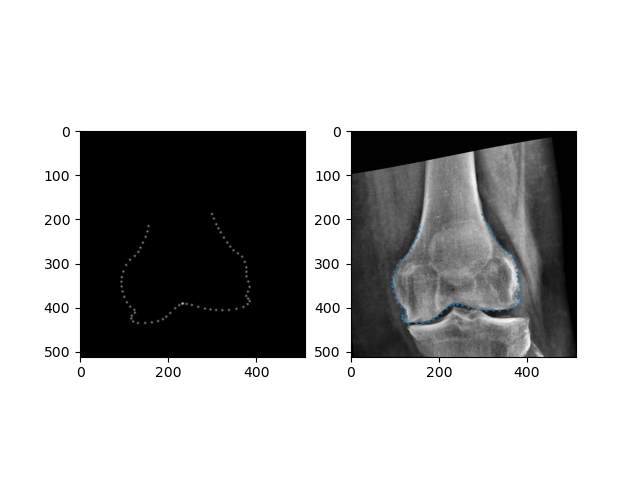

In [12]:
sigmas = torch.zeros(65,1, dtype=torch.float32).fill_(1.6)
sigmas.requires_grad = True
sample = next(iter(dataloader["trainloader"]))
image, landmarks = sample["image"], sample["landmarks"].squeeze_(dim=0).detach().numpy()

prediction = torch.from_numpy(np.random.rand(landmarks.shape[0], 512, 512))
import time
start_time = time.time()
heatmaps = heatmap_new_method(landmarks, sigmas).squeeze_(dim=0)
end_time =  time.time()
print(str(end_time-start_time), heatmaps.max(), heatmaps.min())

loss = torch.nn.functional.mse_loss(prediction, heatmaps, reduction="sum")
loss.backward()

#print(np.allclose(heatmaps, heatmaps_new))

heatmap = np.zeros(heatmaps.shape[1:])
for hid, h in enumerate(heatmaps):
    heatmap += h.detach().numpy()

image = image.squeeze_(dim=0).cpu().numpy()
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(heatmap, "gray")
#ax1.scatter(landmarks[:, 0], landmarks[:, 1], s=0.5)
ax2.imshow(image, "gray")
ax2.scatter(landmarks[:, 0], landmarks[:, 1], s=0.5)
plt.show()

In [7]:
scn = SCN(65)
use_cuda =  torch.cuda.is_available()

sigmas = torch.zeros(65,1, dtype=torch.float32).fill_(1.5)
sigmas.requires_grad = True

if use_cuda:
    scn = scn.cuda()
optimizer = optim.SGD([
                {'params':scn.parameters(), 'weight_decay': weight_decay},
                {'params':sigmas, 'weight_decay':alpha}
            ], lr=lr, momentum=0.9, nesterov=True)
criterion = torch.nn.MSELoss(reduction="sum")
#heatmapconverter = ConvertToHeatmaps()
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=0.000001, verbose=True)

Initializing weights


In [6]:
import time
torch.autograd.set_detect_anomaly(True)
def train(n_epochs, loaders, heatmapgenerator, sigmas, model, optimizer, criterion, use_cuda=True, save_path=".\\weights\\model_dict.pt", load_weights=False, scheduler=None):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    if load_weights:
        model_dict = torch.load(save_path)
        model.load_state_dict(model_dict["model_state_dict"])
        optimizer.load_state_dict(model_dict["optimizer_state_dict"])
        valid_loss_min = model_dict["loss"]
        sigmas = model_dict["sigmas"]
        sigmas.requires_grad = True
        print("model, optimizer, sigmas and loss loaded")
        
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        start_time = time.time()
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, sample in enumerate(loaders['trainloader']):
            optimizer.zero_grad()
            # move to GPU
            image, landmarks = sample["image"].unsqueeze_(dim=1).type(torch.float), sample["landmarks"].squeeze_(dim=0).detach().numpy()
            #landmarks.requires_grad = False
            heatmaps = heatmapgenerator(landmarks, sigmas)
            
            if use_cuda:
                image, heatmaps = image.cuda(), heatmaps.cuda()
            prediction = model(image)
            loss = criterion(prediction, heatmaps)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 50 == 0:
                print('Epoch: {} \tTraining Loss: {:.6f} after {} epoch'.format(epoch, train_loss, batch_idx))
                torch.save({'sigmas':sigmas}, "sigmas.pt")
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, sample in enumerate(loaders['validloader']):
            # move to GPU
            image, landmarks = sample["image"].unsqueeze_(dim=1).type(torch.float), sample["landmarks"].squeeze_(dim=0).detach().numpy()
            #landmarks.requires_grad = False
            heatmaps = heatmapgenerator(landmarks, sigmas)
            if use_cuda:
                image, heatmaps = image.cuda(), heatmaps.cuda()
            ## update the average validation loss
            with torch.no_grad():
                prediction = model(image)
                loss = criterion(prediction, heatmaps)
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
        
        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        if scheduler is not None:
            scheduler.step(valid_loss) 
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min :
            valid_loss_min = valid_loss
            model_dict = {'model_state_dict':model.state_dict(), 'optimizer_state_dict':optimizer.state_dict(), 'loss':valid_loss_min, 'sigmas':sigmas}
            torch.save(model_dict, save_path)
        end_time = time.time()
        print("Training Epoch  "+str(epoch)+" th finished in "+str(end_time-start_time))
    return model

In [7]:
num_iterations = 10
scn = train(num_iterations, dataloader, heatmap_new_method, sigmas, scn, optimizer, criterion, load_weights=True)

model, optimizer, sigmas and loss loaded
Epoch: 1 	Training Loss: 40.663795 after 0 epoch
Epoch: 1 	Training Loss: 40.204613 after 50 epoch
Epoch: 1 	Training Loss: 39.887920 after 100 epoch
Epoch: 1 	Training Loss: 39.998665 after 150 epoch
Epoch: 1 	Training Loss: 40.094730 after 200 epoch
Epoch: 1 	Training Loss: 40.024433 after 250 epoch
Epoch: 1 	Training Loss: 40.020878 after 300 epoch
Epoch: 1 	Training Loss: 40.102074 after 350 epoch
Epoch: 1 	Training Loss: 40.098156 after 400 epoch
Epoch: 1 	Training Loss: 40.129677 after 450 epoch
Epoch: 1 	Training Loss: 40.089142 after 500 epoch
Epoch: 1 	Training Loss: 40.078491 after 550 epoch
Epoch: 1 	Training Loss: 40.093891 after 600 epoch
Epoch: 1 	Training Loss: 40.101196 	Validation Loss: 40.119045
Training Epoch  1 th finished in 2730.2513053417206
Epoch: 2 	Training Loss: 41.067169 after 0 epoch


KeyboardInterrupt: 

In [35]:
model_dict = torch.load(".\\weights\\model_65_dict.pt")
scn.load_state_dict(model_dict["model_state_dict"])
sigmas = model_dict["sigmas"]
#print(model_dict['loss'])
#print(sigmas)
sample = next(iter(dataloader["validloader"]))
scn.eval()
image, landmarks = sample["image"].unsqueeze_(dim=1).type(torch.float), sample["landmarks"].squeeze_(dim=0).detach().numpy()
#landmarks.requires_grad = False
heatmaps = heatmap_new_method(landmarks, sigmas)
if use_cuda:
    image, heatmaps = image.cuda(), heatmaps.cuda()
with torch.no_grad():
    prediction = scn(image)
    diff = (prediction - heatmaps)
    loss = criterion(prediction, heatmaps)
    print(loss.data)

heatmaps = heatmaps.cpu().squeeze_(dim=0)
heatmap = torch.zeros(heatmaps.shape[1:])
for h in heatmaps:
    heatmap += h
predictions = torch.zeros(heatmaps.shape[1:])

prediction = prediction.cpu().squeeze_(dim=0)
for p in prediction:
    predictions+= p

heatmap = heatmap.detach().numpy()
predictions = predictions.detach().numpy()
image = image.squeeze_(dim=0).squeeze_(dim=0).cpu().numpy()
predicted_lands = get_coordinates(prediction, landmarks)

predictions = predictions/predictions.max()
print(predictions.shape, predictions.max(), predictions.min())
from skimage import img_as_uint
predictions = img_as_uint(predictions)
canny = cv2.Canny(predictions, 100, 200)
#landmarks = landmarks.cpu()
#print(landmarks, predicted_lands)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(heatmap, "gray")
#ax1.scatter(landmarks[:, 0], landmarks[:, 1], s=0.5)
ax2.imshow(image, "gray")
ax2.scatter(landmarks[:, 0], landmarks[:, 1], s=0.5)
ax2.scatter(predicted_lands[:,0], predicted_lands[:,1], s=0.5)
ax3.imshow(predictions, "gray")
plt.show()
#print(find_maximum_coord_in_image(prediction.detach().numpy()[5]), landmarks[5], find_maximum_coord_in_image(heatmaps.detach().numpy()[5]))

tensor(39.5023, device='cuda:0')
torch.Size([65, 512, 512])
(512, 512) 1.0 -0.10219893


error: OpenCV(3.4.2) C:\Miniconda3\conda-bld\opencv-suite_1534379934306\work\modules\imgproc\src\canny.cpp:947: error: (-215:Assertion failed) _src.depth() == 0 in function 'cv::Canny'


In [10]:
def find_maximum_coord_in_image(image):
    # calculate maximum
    max_index = np.argmax(image)
    print(max_index)
    coord = np.array(np.unravel_index(max_index, image.shape), np.int32)
    return coord

In [11]:
def get_coordinates(heatmaps, landmarks):
    print(heatmaps.shape)
    coords = np.zeros((heatmaps.shape[0], 2), dtype=np.float32)
    for hid, heatmap in enumerate(heatmaps):
        max_index = np.argmax(heatmap)
        coords[hid] = np.flip(np.array(np.unravel_index(max_index, heatmap.shape), np.int32), axis=0)
        #print(landmarks[hid], coords[hid])
    return coords